# Upper Slope & Axis 75 kHz ADCP

Primary notebook to create various spectral and velocity plots for either the Upper Slope or Axis ADCP velocity data.

## Imports

Necessary modules for analysis.

In [2]:
import xarray as xr
import datetime
import cmath
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.integrate as integ
import scipy.interpolate as interp
import pandas as pd
import seawater as sea
from scipy.stats import chi2
from scipy.io import loadmat
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

## Data

Choose Upper Slope or Axis data, in NetCDF format, and visualise data to check for coverage.

In [51]:
adcp = 'Axis'     # Slope, Axis, Axis55
name = adcp         # name of instrument, for plots

if adcp == 'Slope':
    ds = xr.open_dataset(f'../Data/{adcp}All/{adcp}_all.nc')
    ds = ds.drop_dims('longitude')
    ds = ds.drop_dims('latitude')
elif adcp == 'Axis':
    ds = xr.open_dataset(f'../Data/{adcp}All/{adcp}_all.nc')
    ds = ds.drop_dims('longitude')
    ds = ds.drop_dims('latitude')
elif adcp == 'Axis55':
    ds = xr.open_dataset(f'../Data/AxisAll/{adcp}_all.nc')
    name = 'Axis'   # for consistent naming between Axis 75 and 55 kHz
    
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 422, time: 162119)
Coordinates:
  * depth    (depth) float32 336.2703 336.27032 ... 968.27594 970.27026
  * time     (time) datetime64[ns] 2012-06-02T05:07:29.999996672 ... 2018-06-22T10:52:30
Data variables:
    u        (time, depth) float32 ...
    v        (time, depth) float32 ...
    w        (time, depth) float32 ...
    temp     (time) float32 ...
Attributes:
    Conventions:                             CF-1.6
    title:                                   Ocean Networks Canada RDI ADCP Data
    institution:                             Ocean Networks Canada
    source:                                  Fixed-position Teledyne-RDI ADCP...
    history:                                 data extracted from raw output, ...
    references:                              http://www.oceannetworks.ca/
    CREATION_DATE:                           20200127T191616Z
    time_coverage_start:                     20120602T050730Z
    time_coverage_end:          

<IPython.core.display.Javascript object>


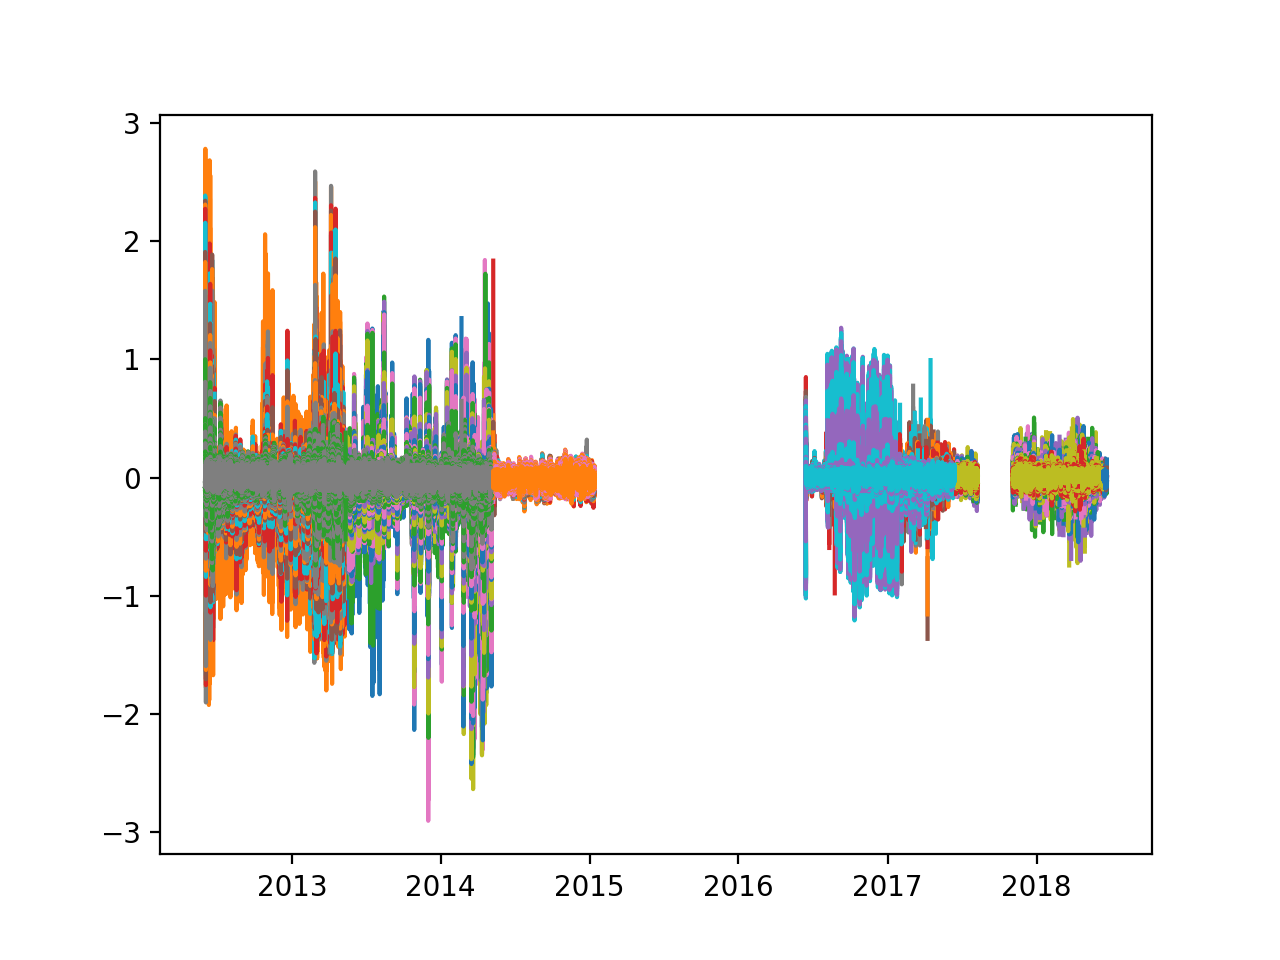

In [143]:
plt.plot(ds.time,ds.u)
plt.show()

## Depth

Truncate data to a specific depth interval to eliminate unreliable data (from visual inspection of velocity plots), approximately 50-100 m from the upper and lower extremes of the ADCP beams.

In [4]:
# function to find nearby indices for desired depth values
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest depth value

array = ds.depth    # input array to process 
if adcp=='Slope':
    upval = 100         # upper depth for data, metres (upper slope)
    lowval = 330        # lower depth for data (upper slope)
elif adcp=='Axis':
    upval = 400         # upper depth for data, metres (axis)
    lowval = 900        # lower depth for data (axis)
elif adcp=='Axis55':
    upval = 400         # upper depth for data, metres (axis)
    lowval = 900        # lower depth for data (axis)
    
upidx = find_nearest(array, upval)                 # index of upper depth cutoff
lowidx = find_nearest(array,lowval)+1              # index of lower depth cutoff 

print("Index at upper depth cutoff:", upidx)
print("Value at upper depth cutoff:", -ds.depth.values[upidx], "metres" )
print('---')
print("Index at lower depth cutoff:", lowidx)
print("Value at lower depth cutoff:", -ds.depth.values[lowidx], "metres" )

depth = np.array(ds.depth[upidx:lowidx+1])         # remove unwanted depths
dup_stamp = int(-depth[0])                         # depth stamps for use in output filenames
dlow_stamp = int(-depth[-1])

print('---')
print("Length of new depth array: ", len(depth))   # new depth interval
print(f'Upper limit at',dup_stamp,'metres')         # depth for upper PSD
print(f'Lower limit at',dlow_stamp,'metres')        # depth for lower PSD

Index at upper depth cutoff: 48
Value at upper depth cutoff: -400.2703 metres
---
Index at lower depth cutoff: 377
Value at lower depth cutoff: -904.2703 metres
---
Length of new depth array:  330
Upper limit at -400 metres
Lower limit at -904 metres


## Time

Find specific time range and format dates for plotting. If significant *consecutive* NaN values are present, then shorten series for that particular segment.

In [6]:
datestimes = pd.to_datetime(ds.time.values)            # convert to datetime from datetime64
datestimes = pd.Series(datestimes)                     # convert to pandas dataframe

start_date = pd.datetime(2013,1,1)
end_date = pd.datetime(2014,1,1)
start = datestimes[datestimes >= start_date].index[0]                # desired start date
end = datestimes[datestimes < end_date].index[-1]                    # desired end date
time_total = ds.time.values[start:end]                               # total desired interval
print("Desired time range:",np.min(time_total),np.max(time_total))   # print to check desired interval

# check new time series for significant NaN values
depth_test = ds.depth[lowidx]                          # mid-depth for ideal data (less noise, etc.)   
print('checked at depth',ds.depth.values[lowidx],'m')
u_test = np.array(ds.u[start:end,lowidx])              # u data at this depth
NaN_series = np.zeros(len(u_test))                     # empty array to indicate NaN values
counter = 0                                            # counter to keep track of # of consecutive NaN values
for i in range(len(time_total)):                       # loop to count consecutive NaN values
    if np.isnan(u_test[i])==True:                      # add to counter if NaN = true
        NaN_series[i] = 1
        counter += 1
        if counter==2688:                              # a consecutive month worth of NaN
            dead = i-2688                              # date time series hits significant NaN interval
            print("Time series hits trouble AFTER date:",time_total[dead])
            time_new = time_total[0:dead]              # new truncated interval
            end -= (len(time_total)-len(time_new))     # new end date 
            print("Good data time range:",np.min(time_new),np.max(time_new))
    elif np.isnan(u_test[i])==False:                   # reset counter if NaN inconsistent
        counter = 0       

# usable interval, for next steps
time = ds.time.values[start:end]    

# set year time stamp for output filenames
t_stamp = f'{datestimes.dt.year[start]}'

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


Desired time range: 2013-01-01T00:07:30.000003328 2013-12-31T23:37:30.000000000
checked at depth 904.2703 m


## Filters

Digital, 40h low-pass Butterworth filter to remove tides and observe mean currents, when necessary.

In [7]:
# low pass Butterworth filter for 40 hour cut-off to remove 30 hour tides

fs = 4                # samples per HOUR for entire time series
fc = 0.025            # 40 hour low pass filter cut-off
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(8, Wn,'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)

## Clean

Data rotated based on a visual estimate of along-slope angle, as 30$^{\circ}$. This could be updated to reflect Thomson's work at the A1 site, relatively nearby.

Data are also interpolated to deal with minor instances of NaN values in both depth and time. Consistent NaN intervals are dealt with in the Time section, above.

In [57]:
# rotate data
theta_along_slope = np.radians(30)                       # rotation angle in radians, 30 degrees
u_vec = ds.u[start:end,upidx:lowidx+1] + 1j*ds.v[start:end,upidx:lowidx+1]  # vector form of horizontal velocity
u_vec_new = u_vec*np.exp(-1j*theta_along_slope)          # rotated velocity vector
u_rot = np.real(u_vec_new)                               # u_new = Re(rotated vector)
v_rot = np.imag(u_vec_new)                               # v_new = Im(rotated vector)

# filter NaN instances from data
t = len(time)                  # number of time data points after checking for consistent NaN intervals
d = len(depth)                 # number of depth data points after removing unwanted depths

uorig = np.empty([t,d])        # empty array for rotated u data
vorig = np.empty([t,d])        # empty array for rotated v data

for j in range(d):                       # loop to interpolate velocities at each depth
    utemp = pd.Series(u_rot[:,j])
    uint = utemp.interpolate(method="linear", limit_direction='both')
    uorig[:,j] = uint                    # set interpolated data to original array
    
    vtemp = pd.Series(v_rot[:,j])
    vint = vtemp.interpolate(method="linear", limit_direction='both')
    vorig[:,j] = vint                    # set interpolated data to original array
    
for i in range(t):                       # loop to interpolate missing depth values
    utemp = pd.Series(uorig[i,:])
    uint = utemp.interpolate(method="linear", limit_direction='both')
    uorig[i,:] = uint
    
    vtemp = pd.Series(vorig[i,:])
    vint = vtemp.interpolate(method="linear", limit_direction='both')
    vorig[i,:] = vint
    
ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
uhp = np.empty([t,d])          # empty array for residual u values
vhp = np.empty([t,d])          # empty array for residual v values

for j in range(d):             # loop for filtered and residual velocities
    uint = uorig[:,j]
    ulp[:,j] = sig.filtfilt(b, a, uint)
    uhp[:,j] = uint - ulp[:,j]
    
    vint = vorig[:,j]
    vlp[:,j] = sig.filtfilt(b, a, vint)
    vhp[:,j] = vint - vlp[:,j]

In [9]:
# same process for w (run above, first)

w_new = ds.w[start:end,upidx:lowidx+1]   # w based on time and depth filters
worig = np.empty([t,d])                  # empty array for rotated w data
wlp = np.empty([t,d])                    # empty array for low-pass filtered w values
whp = np.empty([t,d])                    # empty array for residual w values

for j in range(d):                       # loop to filter NaN instances from velocities at each depth
    wtemp = pd.Series(w_new[:,j])
    wint = wtemp.interpolate(method="linear", limit_direction='both')
    worig[:,j] = wint                    # set interpolated data to original array
    
for i in range(t):                       # loop to filter NaN instances from depth values
    wtemp = pd.Series(worig[i,:])
    wint = wtemp.interpolate(method="linear", limit_direction="both")
    worig[i,:] = wint
    
for j in range(d):                       # loop for filtered and residual velocities
    wint = worig[:,j]
    wlp[:,j] = sig.filtfilt(b, a, wint)
    whp[:,j] = wint - wlp[:,j]

# Spectra

PSD, spectrograms, and rotary spectra.

## PSD

Removes the mean from upper and lower depth limits. Also obtains depth mean data for an average spectra through depth. Performs Welch FFT with adjustable parameters, using a Parzen window and what seems to be an optimal averaging process, based on visual analysis of spectral output. Calculates 95% confidence intervals using a chi$^2$ method. GM reference spectra is being adjusted.

In [10]:
# remove mean from upper and lower depth limits (for good data) for PSD

# upper depth limit
umup = uorig[:,0] - np.mean(uorig[:,0]) 
vmup = vorig[:,0] - np.mean(vorig[:,0])
wmup = worig[:,0] - np.mean(worig[:,0])

# lower depth limit
umlow = uorig[:,-1] - np.mean(uorig[:,-1]) 
vmlow = vorig[:,-1] - np.mean(vorig[:,-1])
wmlow = worig[:,-1] - np.mean(worig[:,-1])

In [23]:
# depth mean data

um_depth = np.zeros(t)           # empty arrays for depth mean data
vm_depth = np.zeros(t)
wm_depth = np.zeros(t)

for i in range(t):               # loops for getting the depth mean value at each time point
    um_depth[i] = np.mean(uorig[i,:])
for i in range(t):
    vm_depth[i] = np.mean(vorig[i,:])
for i in range(t):
    wm_depth[i] = np.mean(worig[i,:])

um_depth -= np.mean(um_depth)    # remove the overall mean for PSD
vm_depth -= np.mean(vm_depth)
wm_depth -= np.mean(wm_depth)  

In [24]:
# Welch FFT
fs_x = 4                     # 4 samples per HOUR
window_x = 'parzen'          # optimal window for averaging
nperseg_x = int(len(time)/40)   # find optimal average for nperseg, use /40 for annual, /20 for seasonal       

# lower depth
umlow_f, umlow_PSD = sig.welch(umlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmlow_f, vmlow_PSD = sig.welch(vmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmlow_f, wmlow_PSD = sig.welch(wmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# upper depth
umup_f, umup_PSD = sig.welch(umup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmup_f, vmup_PSD = sig.welch(vmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmup_f, wmup_PSD = sig.welch(wmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# depth mean
um_depth_f, um_depth_PSD = sig.welch(um_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vm_depth_f, vm_depth_PSD = sig.welch(vm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wm_depth_f, wm_depth_PSD = sig.welch(wm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [13]:
# error bars (95% confidence intervals)

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = len(time) / (nperseg_x / 2)              # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

umlow_lower = umlow_PSD * cint[0]             # define upper and lower confidence values
umlow_upper = umlow_PSD * cint[1]
vmlow_lower = vmlow_PSD * cint[0]             # define upper and lower confidence values
vmlow_upper = vmlow_PSD * cint[1]
wmlow_lower = wmlow_PSD * cint[0]             # define upper and lower confidence values
wmlow_upper = wmlow_PSD * cint[1]

umup_lower = umup_PSD * cint[0]               # define upper and lower confidence values
umup_upper = umup_PSD * cint[1]
vmup_lower = vmup_PSD * cint[0]               # define upper and lower confidence values
vmup_upper = vmup_PSD * cint[1]
wmup_lower = wmup_PSD * cint[0]               # define upper and lower confidence values
wmup_upper = wmup_PSD * cint[1]

In [15]:
# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:, 0]
gm_psd = gm[:, 1]

<IPython.core.display.Javascript object>


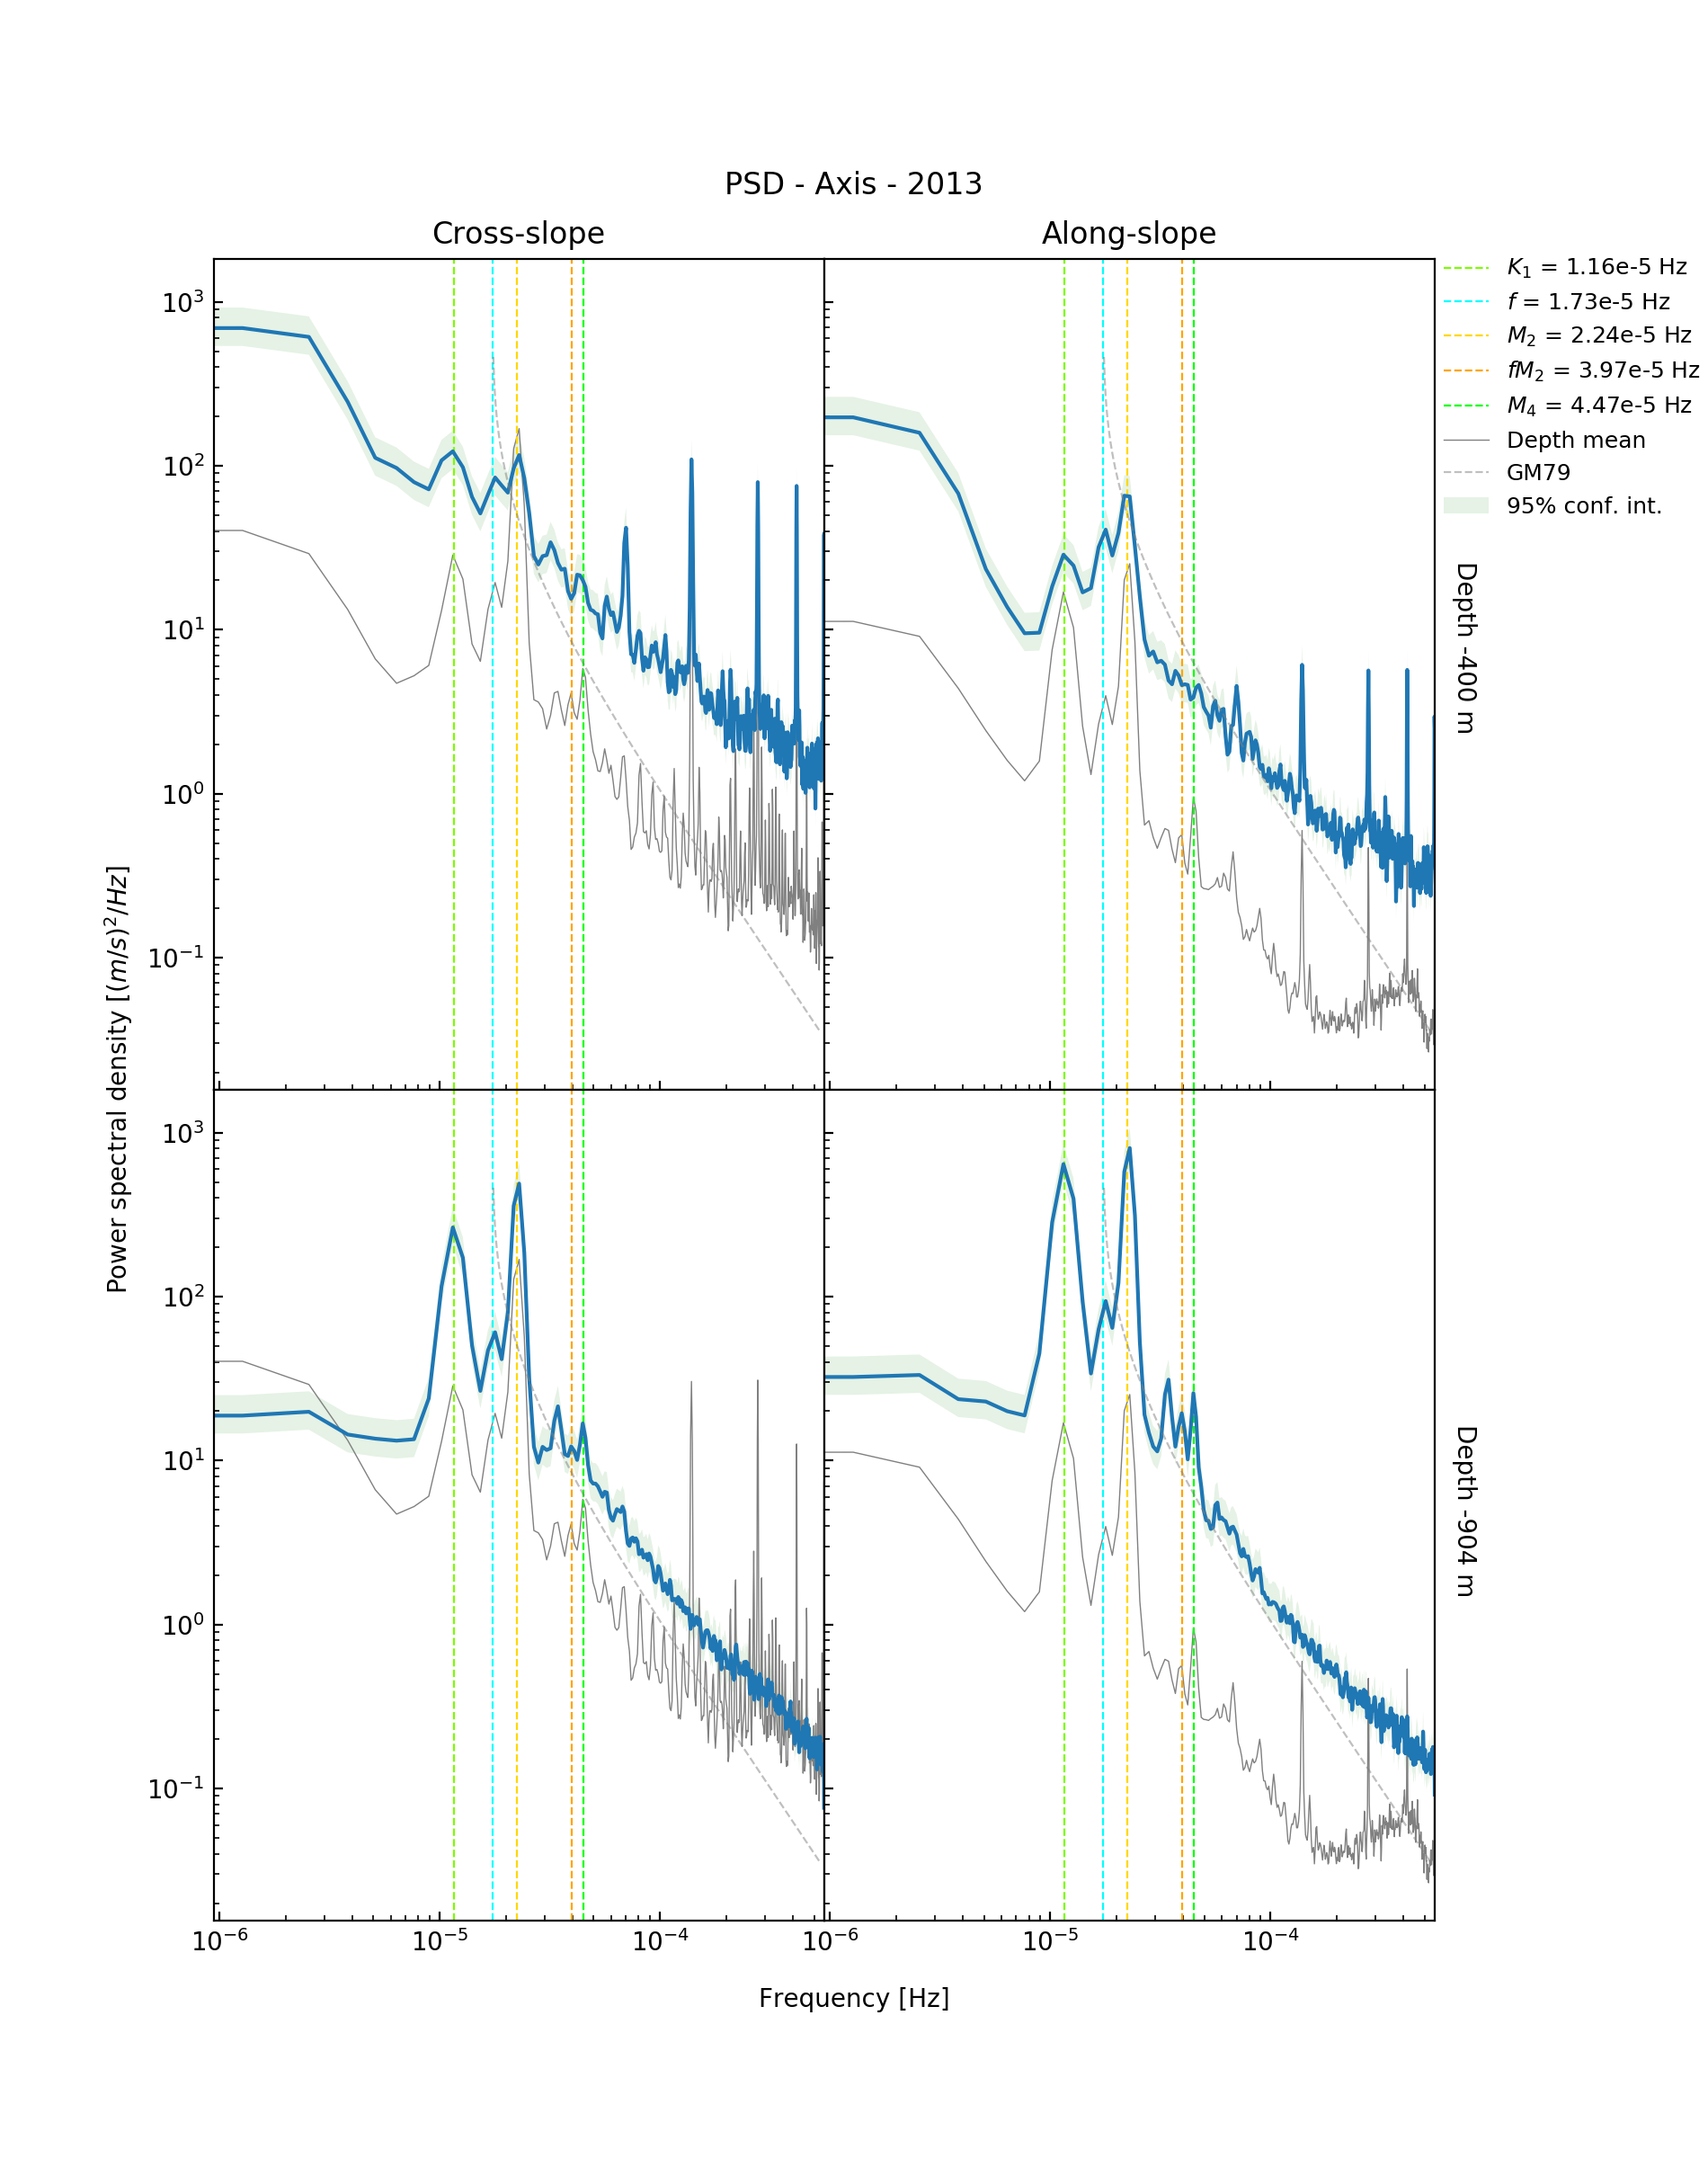

In [25]:
# depth comparison PSD for internal wave band

fig, axs = plt.subplots(2,2,figsize=(9.5,12), sharex=True, sharey=True)
(ax1,ax2),(ax3,ax4) = axs
fig.subplots_adjust(hspace=0, wspace=0)

ax1.loglog(um_depth_f/3600,um_depth_PSD*3600,color='gray',lw=0.5)
ax2.loglog(vm_depth_f/3600,vm_depth_PSD*3600,color='gray',lw=0.5)
ax3.loglog(um_depth_f/3600,um_depth_PSD*3600,color='gray',lw=0.5)
ax4.loglog(vm_depth_f/3600,vm_depth_PSD*3600,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
ax1.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz")    
ax1.axvline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax1.axvline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax1.axvline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax1.loglog(umup_f/3600, umup_PSD*3600)
ax1.tick_params(axis='both', direction='in', which='both')
#ax1.set_ylim(1e-2,8e4)   # for direct comparison between ADCP and years
#ax1.set_ylim(1e-2,5e3)
ax1.set_xlim(None, np.max(um_depth_f/3600))
ax1.set_title('Cross-slope')

ax2.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax2.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax2.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax2.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax2.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(vmup_f/3600, vmup_PSD*3600)
ax2.set_title('Along-slope')

ax3.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax3.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax3.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax3.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax3.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax3.tick_params(axis='both', direction='in', which='both')
ax3.loglog(umlow_f/3600, umlow_PSD*3600)

ax4.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax4.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax4.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax4.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax4.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax4.tick_params(axis='both', direction='in', which='both')
ax4.loglog(vmlow_f/3600, vmlow_PSD*3600)

fig.text(0.85, 0.7, f'Depth {dup_stamp} m', va='center',rotation='270')
fig.text(0.85, 0.3, f'Depth {dlow_stamp} m', va='center',rotation='270')
fig.text(0.5,0.91,f'PSD - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Power spectral density [$(m/s)^2/Hz$]', va='center', rotation='vertical')
fig.text(0.5,0.07,'Frequency [Hz]',ha='center')

ax1.fill_between(umup_f/3600, umup_lower*3600, umup_upper*3600, facecolor='green', alpha=0.1)
ax2.fill_between(vmup_f/3600, vmup_lower*3600, vmup_upper*3600, facecolor='green', alpha=0.1)
ax3.fill_between(umlow_f/3600, umlow_lower*3600, umlow_upper*3600, facecolor='green', alpha=0.1)
ax4.fill_between(vmlow_f/3600, vmlow_lower*3600, vmlow_upper*3600, facecolor='green', alpha=0.1, label='95% conf. int.')

ax1.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='gray',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='gray',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='gray',lw=0.8,ls='--',alpha=0.5)
ax4.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='gray',lw=0.8,ls='--',alpha=0.5, label='GM79') # 1/2 GM for components

plt.subplots_adjust(right=0.84)
fig.legend(loc=(0.84,0.756), fontsize=9, frameon=False)
plt.show()

plt.savefig(fname='./plots/psd_plots/psd_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

<IPython.core.display.Javascript object>


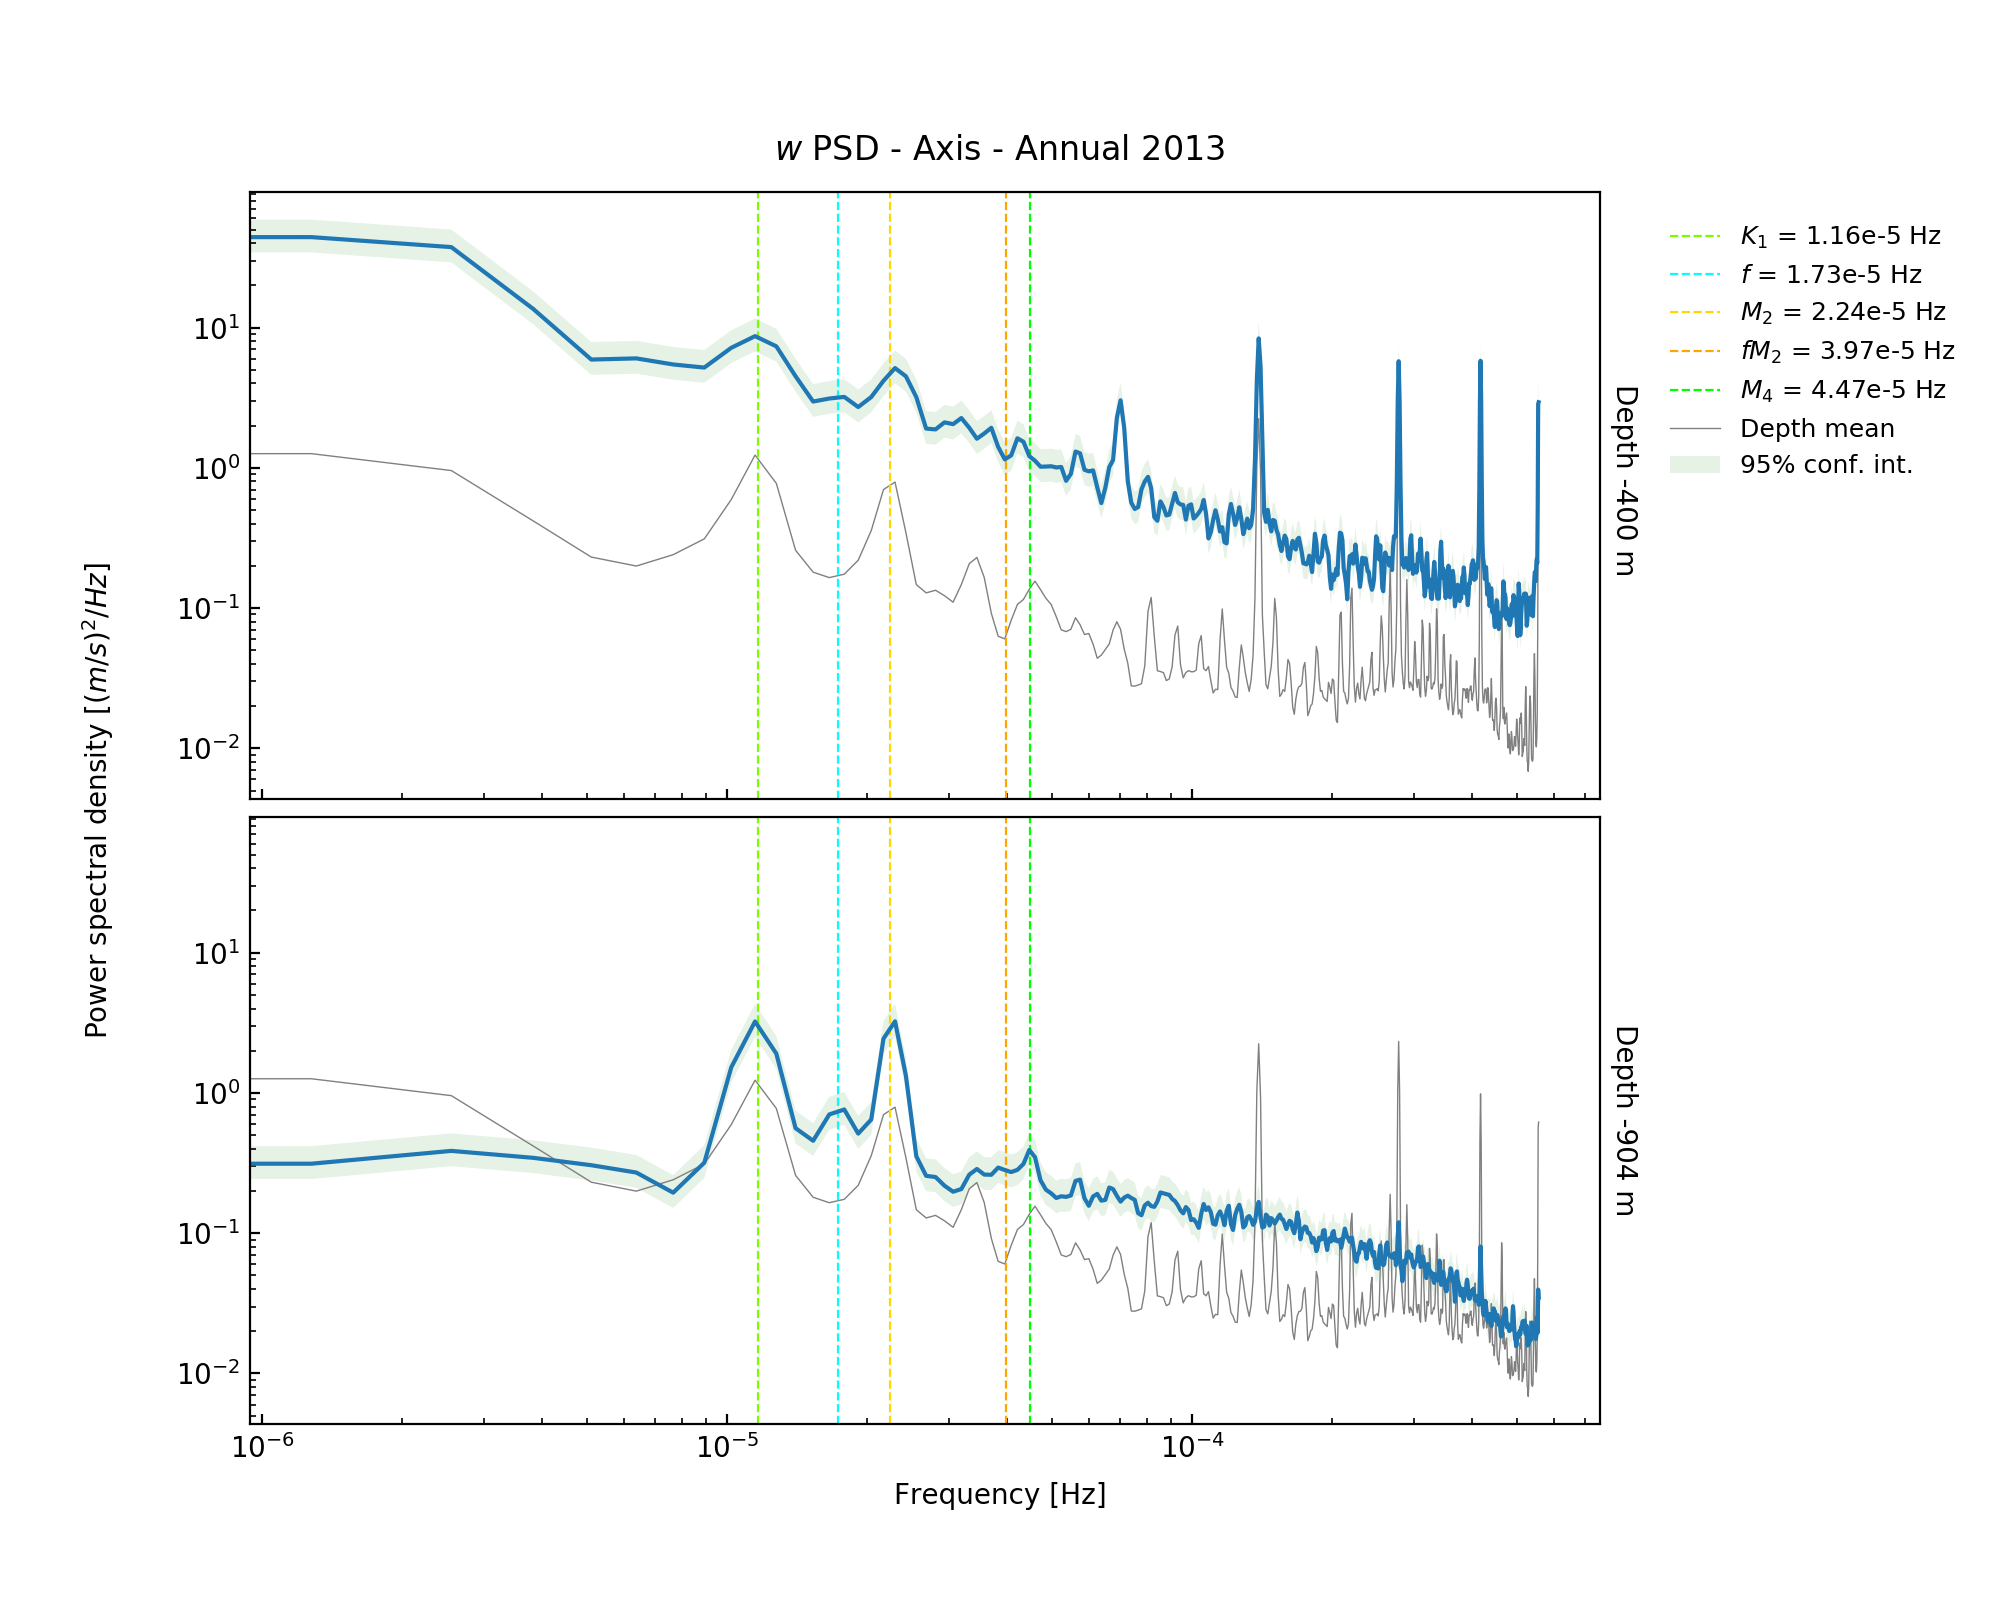

In [26]:
# depth comparison PSD for w velocities

fig, axs = plt.subplots(2,1,figsize=(10,8), sharex=True, sharey=True)
(ax1,ax2) = axs
fig.subplots_adjust(hspace=0.03, wspace=0)

ax1.loglog(wm_depth_f/3600,wm_depth_PSD*3600,color='gray',lw=0.5)
ax2.loglog(wm_depth_f/3600,wm_depth_PSD*3600,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
ax1.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz")    
ax1.axvline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax1.axvline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax1.axvline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax1.tick_params(axis='both', direction='in', which='both')
ax1.loglog(wmup_f/3600, wmup_PSD*3600)
#ax1.set_ylim(1e-3,5e2)
#ax1.set_ylim(1e-2,1e1)
#ax1.set_xlim(np.min(wmup_f/3600),np.max(wmup_f/3600))

ax2.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax2.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax2.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax2.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax2.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(wmlow_f/3600, wmlow_PSD*3600)

fig.text(0.805, 0.7, f'Depth {dup_stamp} m', va='center',rotation='270')
fig.text(0.805, 0.3, f'Depth {dlow_stamp} m', va='center',rotation='270')
fig.text(0.5,0.90,f'$w$ PSD - {name} - Annual {t_stamp}', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Power spectral density [$(m/s)^2/Hz$]', va='center', rotation='vertical')
fig.text(0.5,0.06,'Frequency [Hz]',ha='center')

ax1.fill_between(wmup_f/3600, wmup_lower*3600, wmup_upper*3600, facecolor='green', alpha=0.1)
ax2.fill_between(wmlow_f/3600, wmlow_lower*3600, wmlow_upper*3600, facecolor='green', alpha=0.1, label='95% conf. int.')

plt.subplots_adjust(right=0.8)
fig.legend(loc=(0.83,0.695), fontsize=9, frameon=False)
plt.show()

plt.savefig(fname='./plots/psd_plots/psd_'+adcp+'_w_'+t_stamp+'.pdf',format='pdf')

## Rotary

Creates rotary spectra for the mean-removed and cleaned velocity data, and specific depths. Defines a function to return the CW, CCW, cross, and quadrature spectra for any u and v velocity vectors.

Based on Thomson, R. (1997). Data Analysis Methods in Physical Oceanography. pp.427-432,494-500; Gonella, J. (1972) Deep Sea Res. 833-846, and https://pyoceans.github.io/python-oceans/ocfis.html, and further adapted for averaging (Welch) PSD and CSD processes.

In [33]:
# rotary spectra function

def spec_rot(u, v):
    fs = 4                    # samples per hour
    nps = int(len(time)/40)   # find optimal average for nperseg, use /40 for annual, /20 for seasonal
    win = 'parzen'            # window
    puf, pu = sig.welch(u,fs=fs,window=win,nperseg=nps,return_onesided=False)           # auto-spectrum for u
    pvf, pv = sig.welch(v,fs=fs,window=win,nperseg=nps,return_onesided=False)           # auto-spectrum for v
    cuvf, cuv = sig.csd(v,u,fs=fs,window=win,nperseg=nps,return_onesided=False)         # cross spectra (u,v --> v,u)
    quv = cuv.imag                                      # quadrature spectrum, imaginary part of cross spectra
    cw = ((pu + pv) - (2*quv)) / 2                      # rotatory components
    ccw = ((pu + pv) + (2*quv)) / 2
    F = puf                                             # frequency range (two-sided)
    return cuv, quv, cw, ccw, F

In [42]:
# get rotary spectra
d_idx = -1                                              # depth index, use -1 for lower, 0 for upper
d_stamp = str(int(depth[d_idx]))                       # depth stamp for figures
rot_u = uorig[:,d_idx]                 
rot_u -= np.mean(uorig[:,d_idx])                       # remove mean for rotary spectra
rot_v = vorig[:,d_idx]                 
rot_v -= np.mean(vorig[:,d_idx])  

cuv, quv, cw, ccw, f_rot = spec_rot(rot_u,rot_v)       # get rotary components (cw and ccw) and frequency range (f)
half_idx = int((len(cw)/2))                            # discard half spectrum for real data 
cw_real = cw[1:half_idx]*2                             # mult. amplitude by 2 to account for discarded data
ccw_real = ccw[1:half_idx]*2     
f_rot_real = f_rot[1:half_idx]                         # real frequency range (up to Nyquist)

# GM rotary spectra
gm = np.loadtxt('../project/archive/GM/gm.dat')        # get GM data from separate code
gm_freq = gm[:, 0]
gm_cw = gm[:, 2]
gm_ccw = gm[:, 3]

<IPython.core.display.Javascript object>


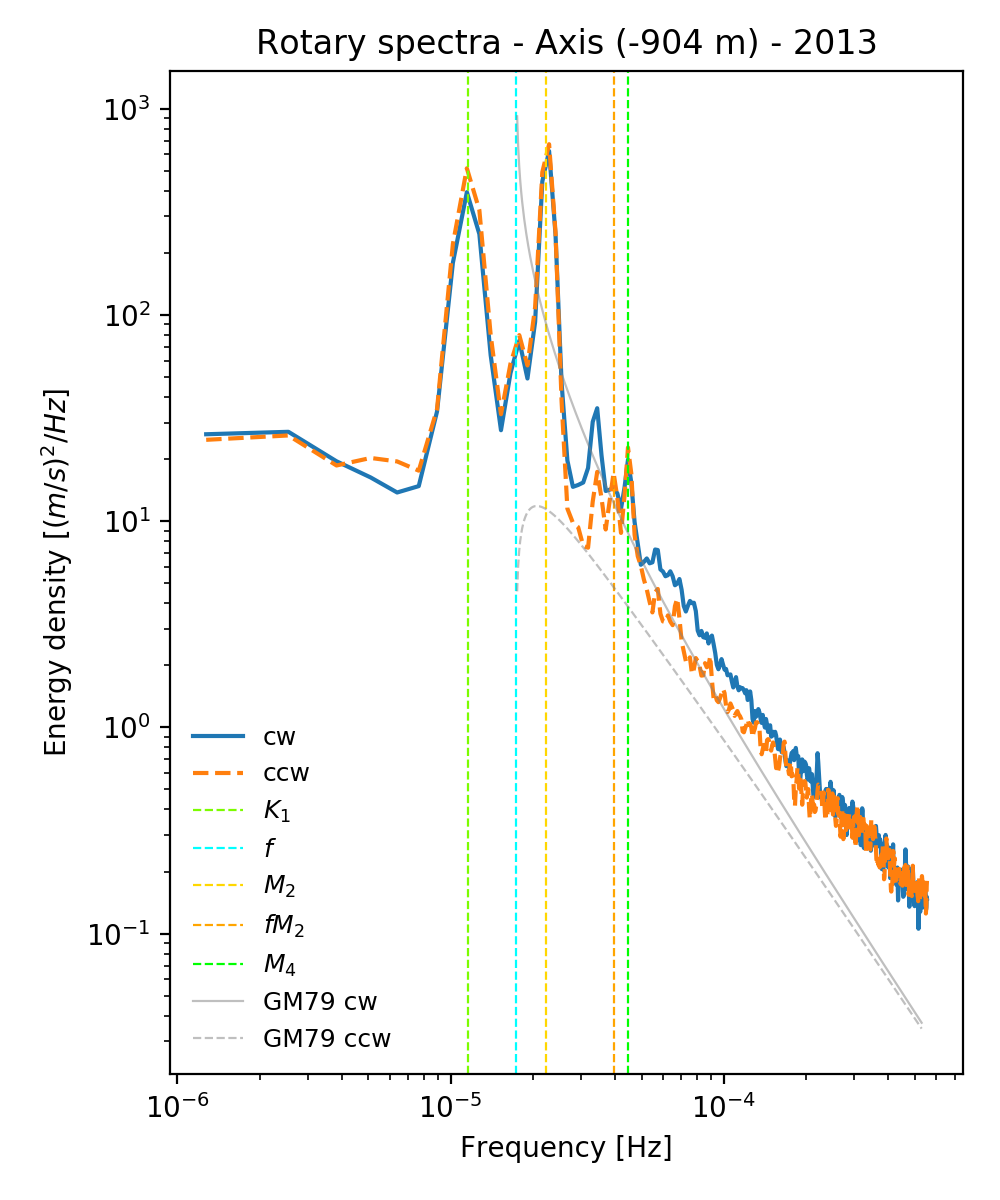

In [43]:
# plot rotary spectra

fig,ax = plt.subplots(1,1,figsize=(5,6))               # plot CCW and CW components
ax.loglog(f_rot_real/3600,cw_real*3600,label='cw')
ax.loglog(f_rot_real/3600,ccw_real*3600,label='ccw',ls='--')
ax.set_title(f'Rotary spectra - {name} (-{d_stamp} m) - {t_stamp}')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(f'Energy density [$(m/s)^2/Hz$]')
ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") 
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$")    
ax.axvline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$")
ax.axvline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$")
ax.axvline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$")
ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='gray',lw=0.8,ls='-',alpha=0.5, label = 'GM79 cw') 
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='gray',lw=0.8,ls='--',alpha=0.5, label = 'GM79 ccw') 
ax.legend(loc='lower left',fontsize=9, frameon=False)
fig.tight_layout()
plt.show()

plt.savefig(fname='./plots/rot_plots/rot_'+adcp+'_'+d_stamp+'_'+t_stamp+'.pdf',format='pdf')

## Spectrogram

Creates a spectrogram for the rotated, cleaned, and mean-removed velocity data. Spectrograms have been 'whitened', and parameters adjusted (as in PSD) for optimal visual clarity.

In [46]:
# set velocity data for spectrogram process
d_idx = 0                                     # depth index, use -1 for lower, 0 for upper
d_stamp = str(int(depth[d_idx]))               # depth stamp for figures
spectro_u = uorig[:,d_idx]                 
spectro_u -= np.mean(uorig[:,d_idx])           # remove mean for spectrogram
spectro_v = vorig[:,d_idx]                 
spectro_v -= np.mean(vorig[:,d_idx])       

# get spectrogram
fs_x = 4                                       # sampling frequency per HOUR
window_x = 'parzen'                            # choose window option
spectro_u_f, spectro_u_t, spectro_u_Sxx = sig.spectrogram(spectro_u, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)
spectro_v_f, spectro_v_t, spectro_v_Sxx = sig.spectrogram(spectro_v, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)

# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
Sxx_u_white = np.copy(spectro_u_Sxx)
for i in range(len(spectro_u_t)):
    Sxx_u_white[:,i] = Sxx_u_white[:,i]*(spectro_u_f**2)
Sxx_v_white = np.copy(spectro_v_Sxx)
for i in range(len(spectro_v_t)):
    Sxx_v_white[:,i] = Sxx_v_white[:,i]*(spectro_v_f**2)

# convert spectro_t to datetime for x-axis on plots
spectro_t4 = spectro_v_t*4
spectro_time_len = len(spectro_t4)
spectro_time_axis = np.zeros([spectro_time_len],dtype='datetime64[s]')
for i in range(spectro_time_len):
    j = np.int(spectro_t4[i])
    spectro_time_axis[i] = time[j]

<IPython.core.display.Javascript object>


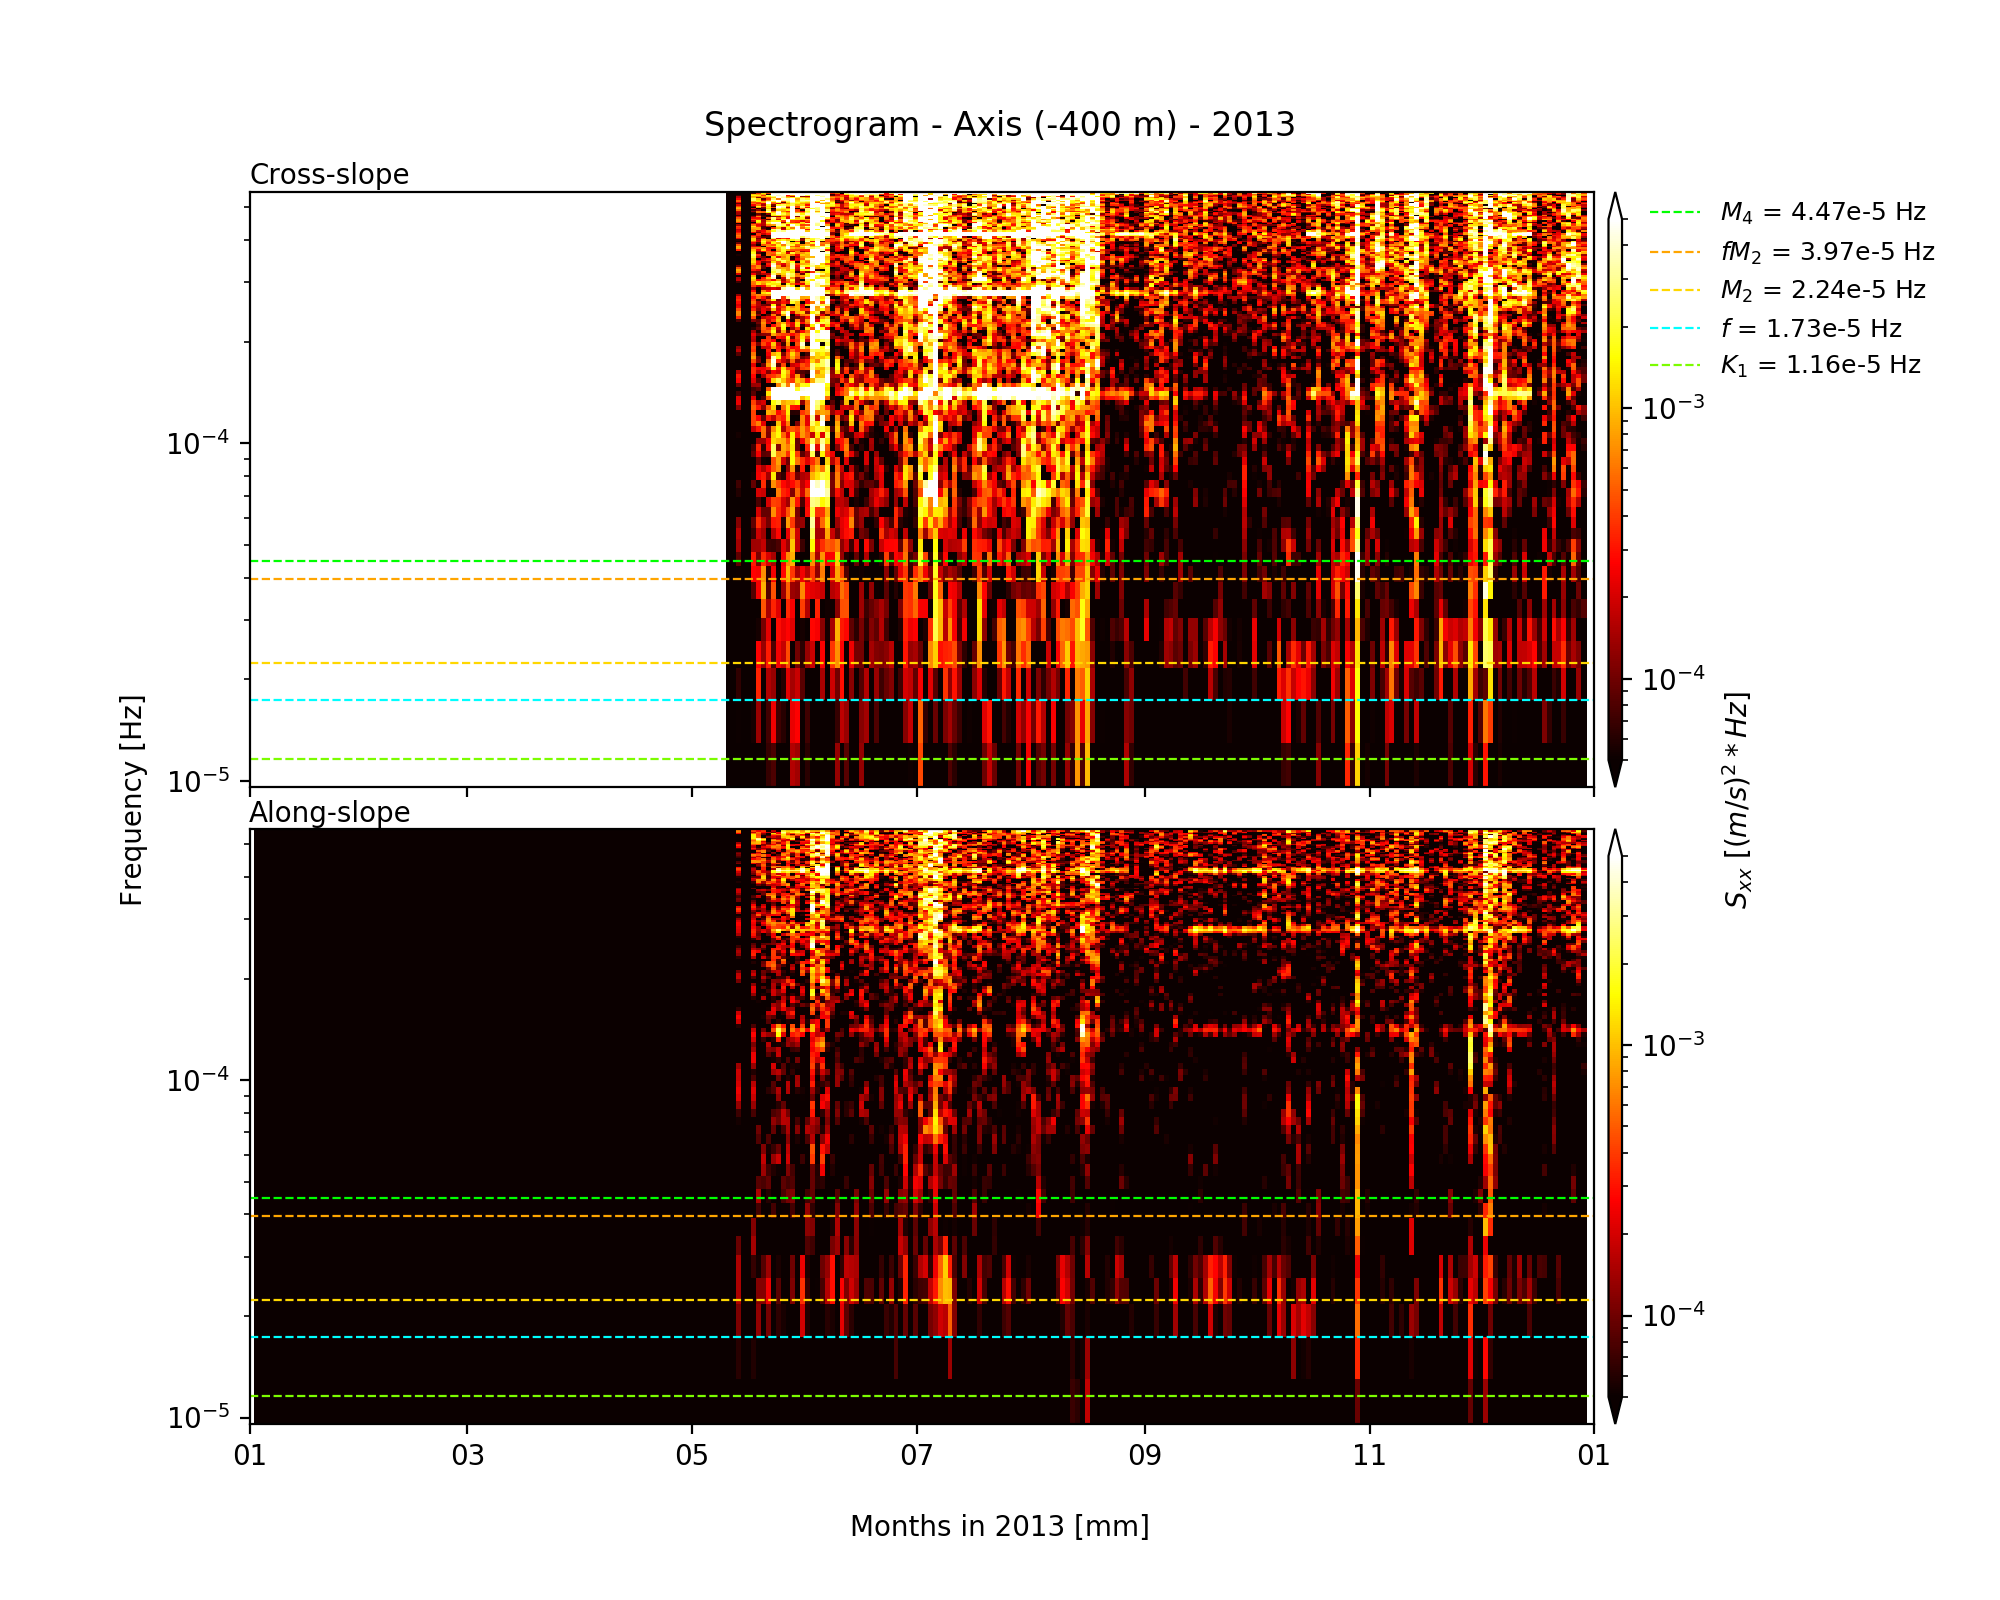

In [47]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.07)
fig.text(0.5, 0.915, f'Spectrogram - {name} (-{d_stamp} m) - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
fig.text(0.86, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, f'Months in {t_stamp} [mm]', ha='center')
fig.text(0.165, 0.885, f'Cross-slope', ha='center')
fig.text(0.165, 0.486, f'Along-slope', ha='center')

im0 = ax0.pcolormesh(spectro_time_axis, spectro_u_f/3600, Sxx_u_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=5e-5, vmax=5e-3), cmap='hot')  
cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=40, extend='both')
im1 = ax1.pcolormesh(spectro_time_axis, spectro_v_f/3600, Sxx_v_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=5e-5, vmax=5e-3), cmap='hot')  
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

ax0.set_yscale('log')
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
#ax0.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))

ax0.axhline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax0.axhline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax0.axhline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax0.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz") 
ax0.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
ax1.axhline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax1.axhline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax1.axhline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax1.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax1.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 

plt.subplots_adjust(right=0.84)
fig.legend(loc=(0.82,0.756), framealpha=0.8, facecolor='whitesmoke', fontsize=9, frameon=False)
plt.show()

plt.savefig(fname='./plots/spectro_plots/spectro_'+adcp+'_'+d_stamp+'_'+t_stamp+'.pdf',format='pdf')

In [115]:
# same process for w (run above, first)

spectro_w = worig[:,d_idx]                 
spectro_w -= np.mean(worig[:,d_idx])       # remove mean for spectrogram

# get spectrogram
spectro_w_f, spectro_w_t, spectro_w_Sxx = sig.spectrogram(spectro_w, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)
# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
Sxx_w_white = np.copy(spectro_w_Sxx)
for i in range(len(spectro_w_t)):
    Sxx_w_white[:,i] = Sxx_w_white[:,i]*(spectro_w_f**2)

<IPython.core.display.Javascript object>


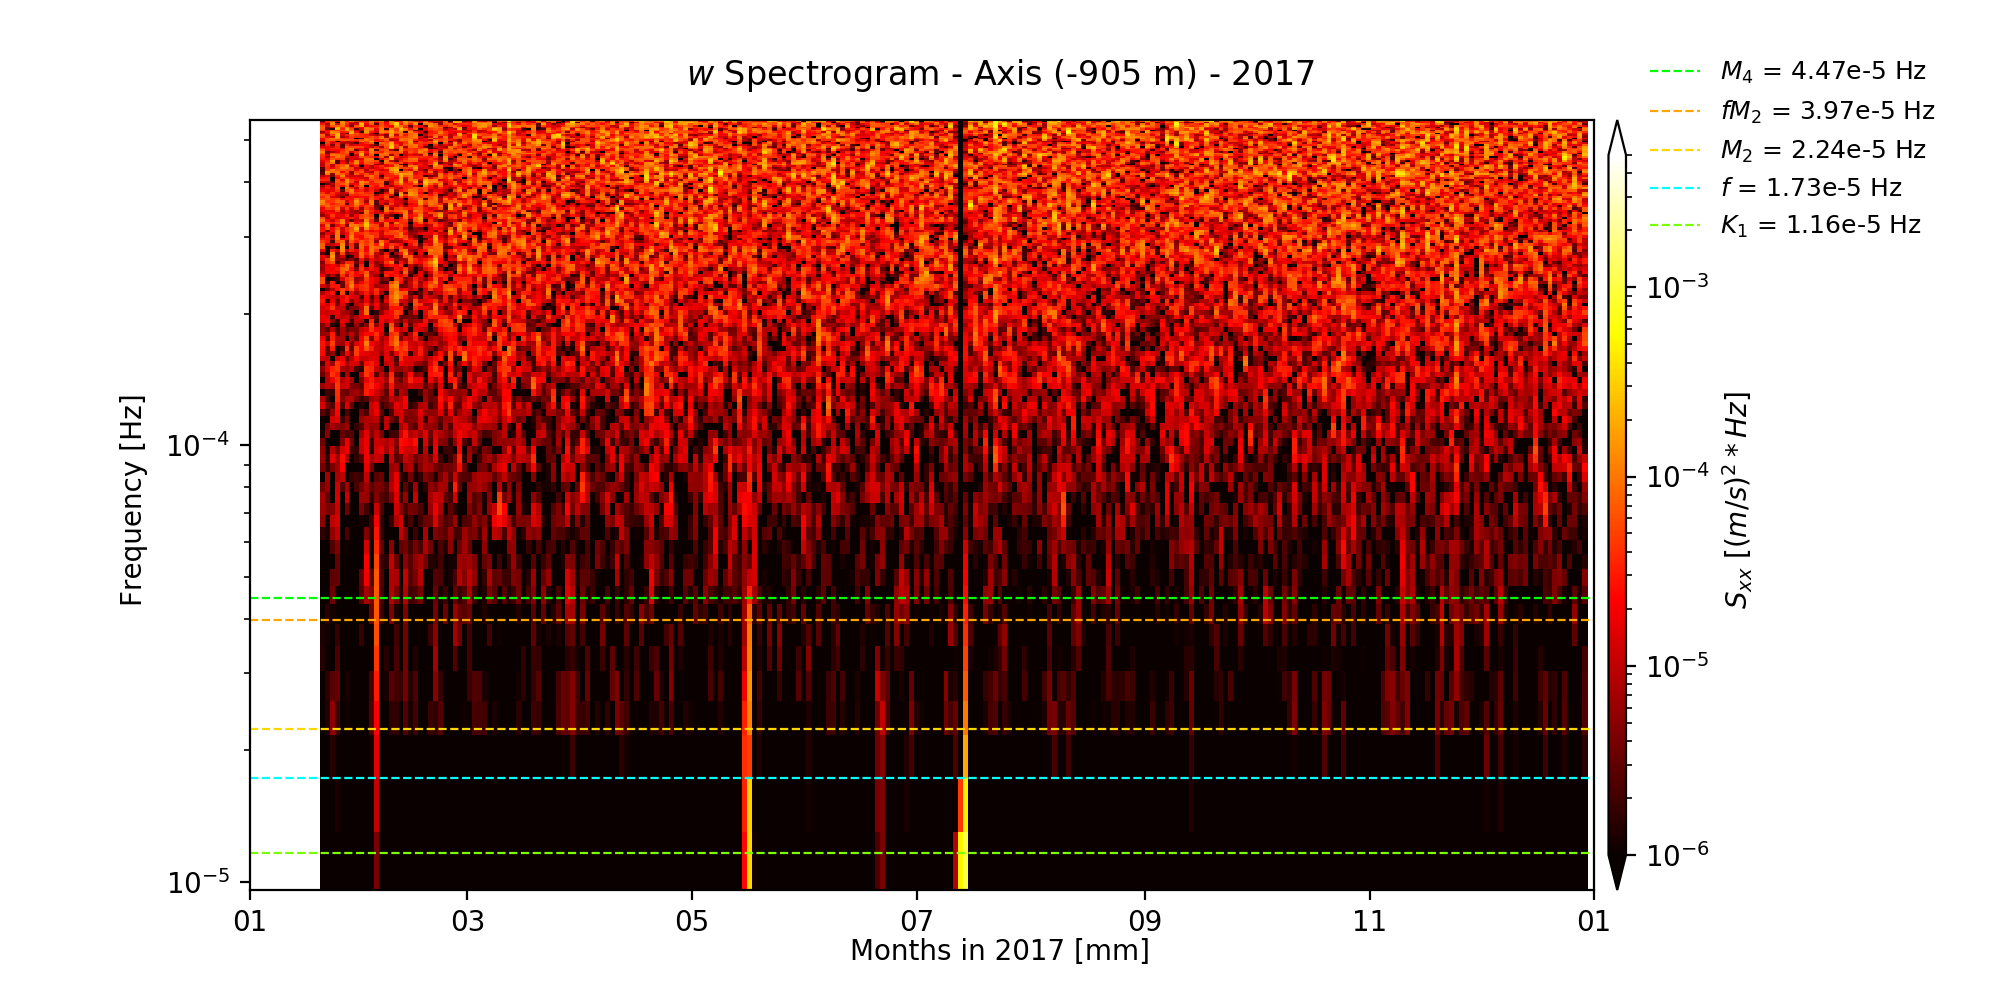

In [116]:
# plot w spectrogram

fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True, sharey=True)
fig.text(0.5, 0.915, f'$w$ Spectrogram - {name} (-{d_stamp} m) - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
fig.text(0.86, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, f'Months in {t_stamp} [mm]', ha='center')

im = ax.pcolormesh(spectro_time_axis, spectro_w_f/3600, Sxx_w_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=1e-6, vmax=5e-3), cmap='hot')  
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')

ax.set_yscale('log')
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlim(start_date,end_date)
#ax.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))

ax.axhline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax.axhline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax.axhline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz") 
ax.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 

plt.subplots_adjust(right=0.84)
fig.legend(loc=(0.82,0.75), framealpha=0.8, facecolor='whitesmoke', fontsize=9, frameon=False)
plt.show()

plt.savefig(fname='./plots/spectro_plots/spectro_'+adcp+'_w_'+d_stamp+'_'+t_stamp+'.pdf',format='pdf')

# Velocities

Creates time and depth velocity plots from rotated and cleaned data.

<IPython.core.display.Javascript object>


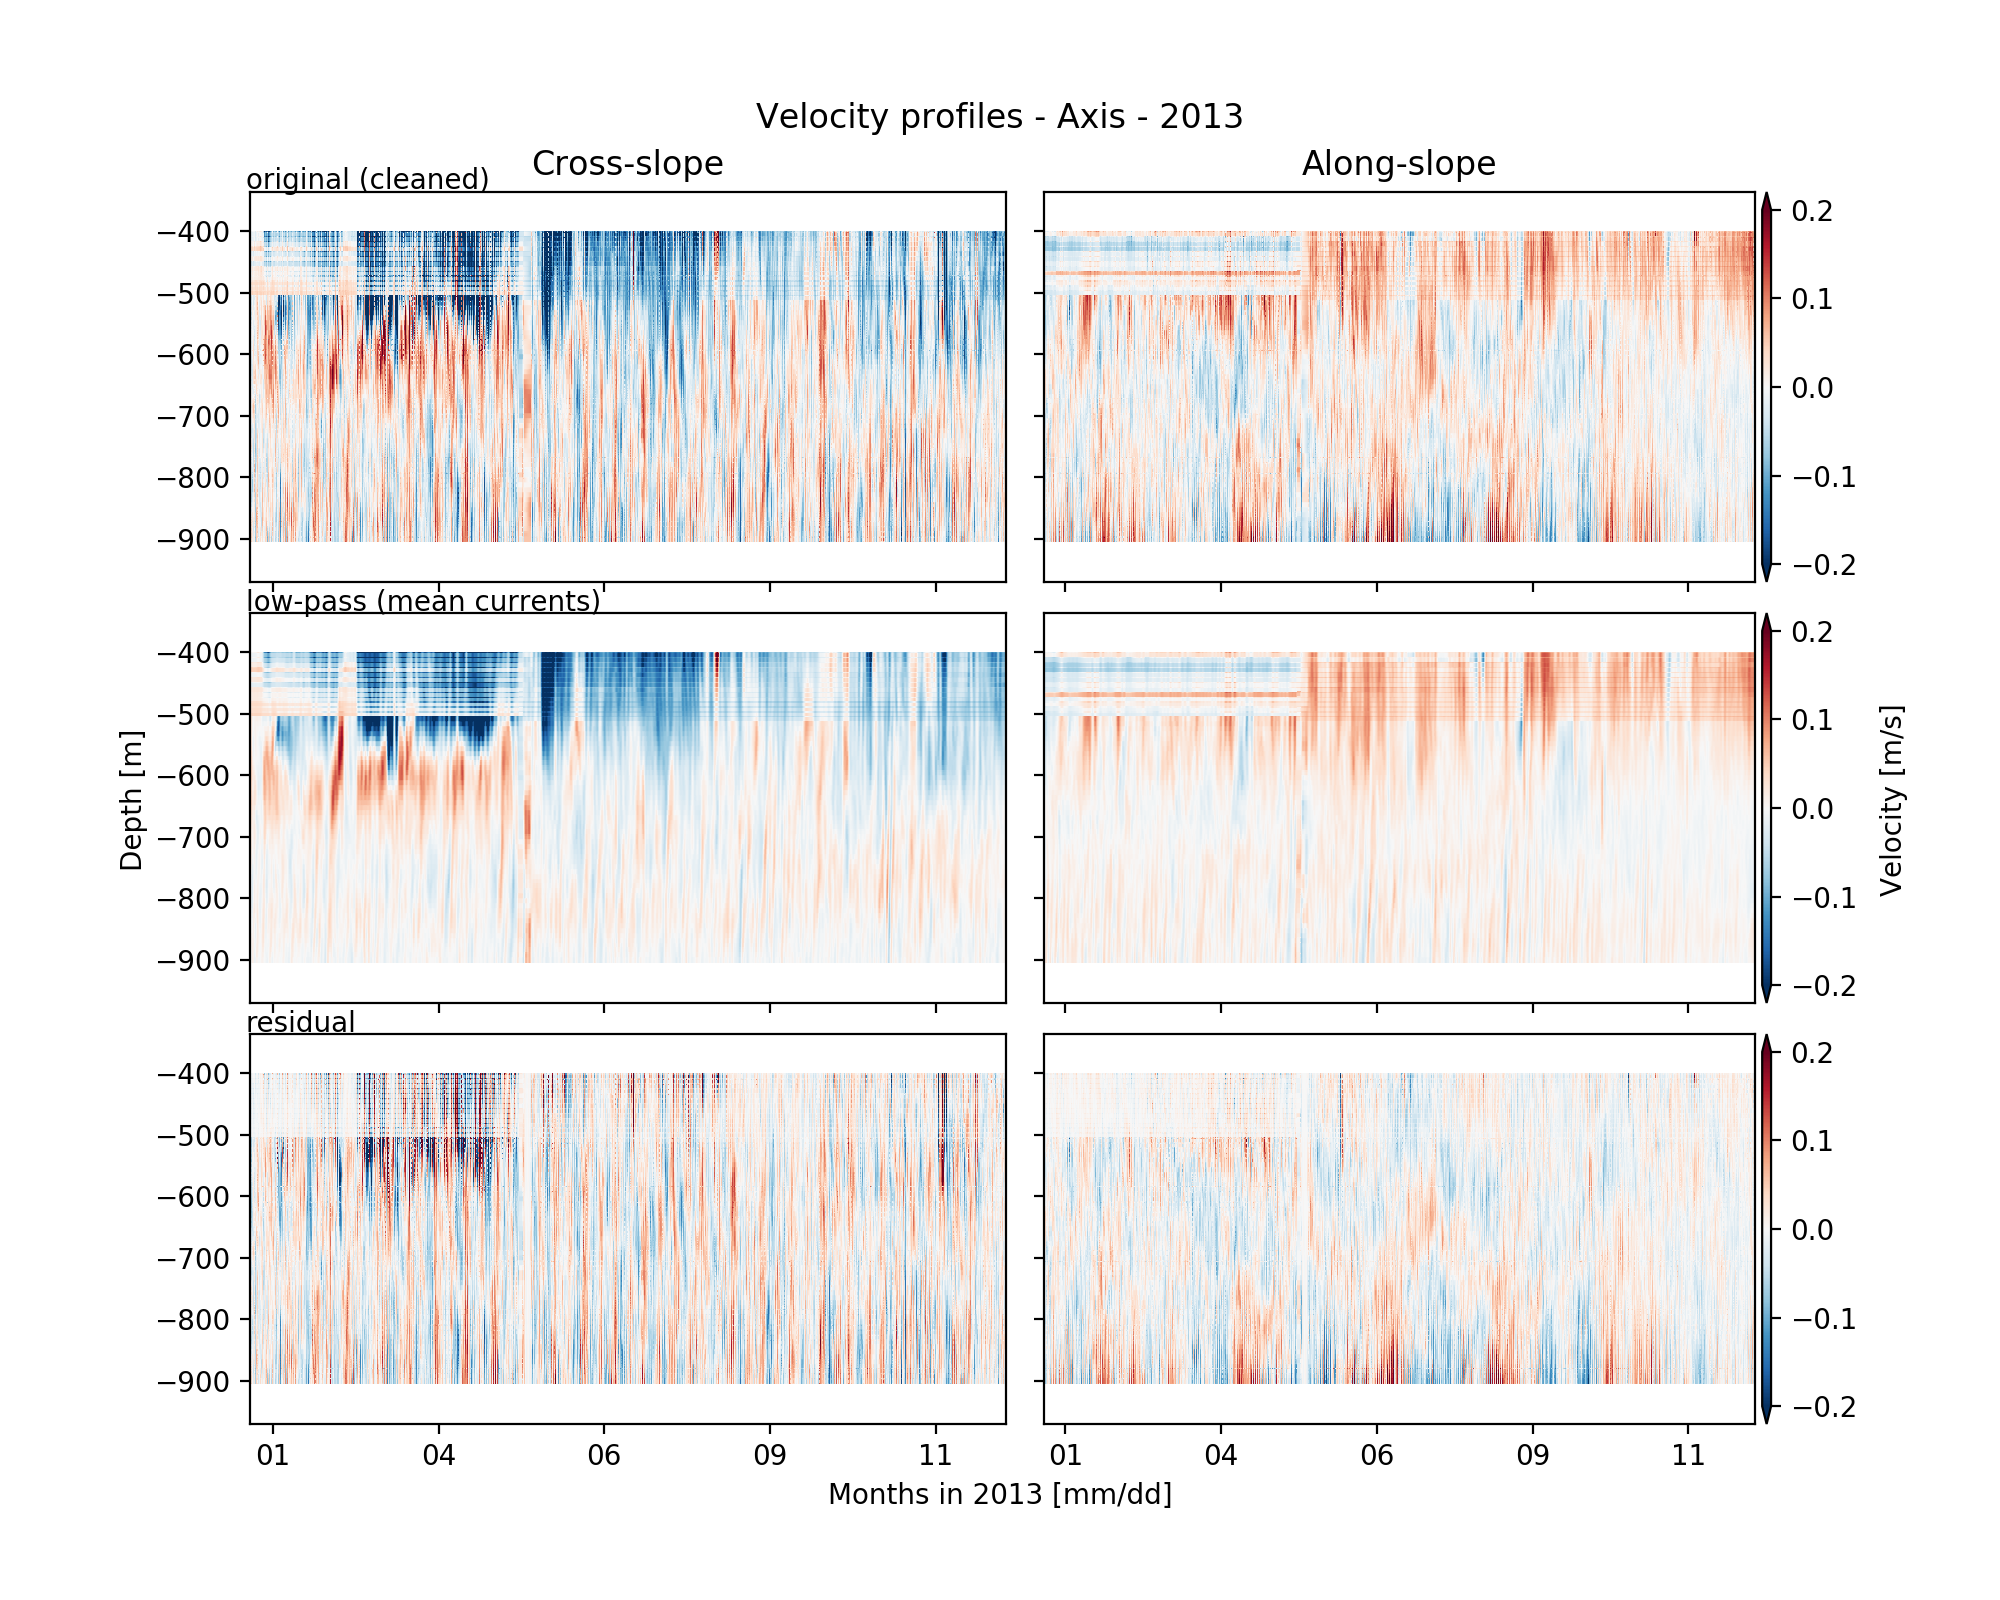

In [58]:
# plot comparative data

fig, axs = plt.subplots(3,2, figsize=(10,8), sharex = True, sharey = True)
(ax1,ax4),(ax2,ax5),(ax3,ax6) = axs
fig.subplots_adjust(hspace = 0.08,wspace = 0.05)
fig.text(0.5, 0.92, f'Velocity profiles - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (cleaned)', va='center')
fig.text(0.123, 0.623, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.360, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm/dd]', ha='center')
ax1.set_title('Cross-slope')
ax4.set_title('Along-slope')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im2 = ax2.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im3 = ax3.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im4 = ax4.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=40, extend='both')
im5 = ax5.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=40, extend='both')
im6 = ax6.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar6 = fig.colorbar(im6, ax=ax6, fraction=0.05, pad=0.01, aspect=40, extend='both')

if adcp == 'Slope':
    ax1.set_ylim(-380,-13)
elif adcp == 'Axis':
    ax1.set_ylim(-970,-336)
elif adcp == 'Axis55':
    ax1.set_ylim(-970,-336)

date_form = pldates.DateFormatter("%m")
ax6.xaxis.set_major_formatter(date_form)
ax6.set_xlim(start_date,end_date)
#ax6.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
ax6.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

plt.savefig(fname='./plots/vel_plots/vel_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

<IPython.core.display.Javascript object>


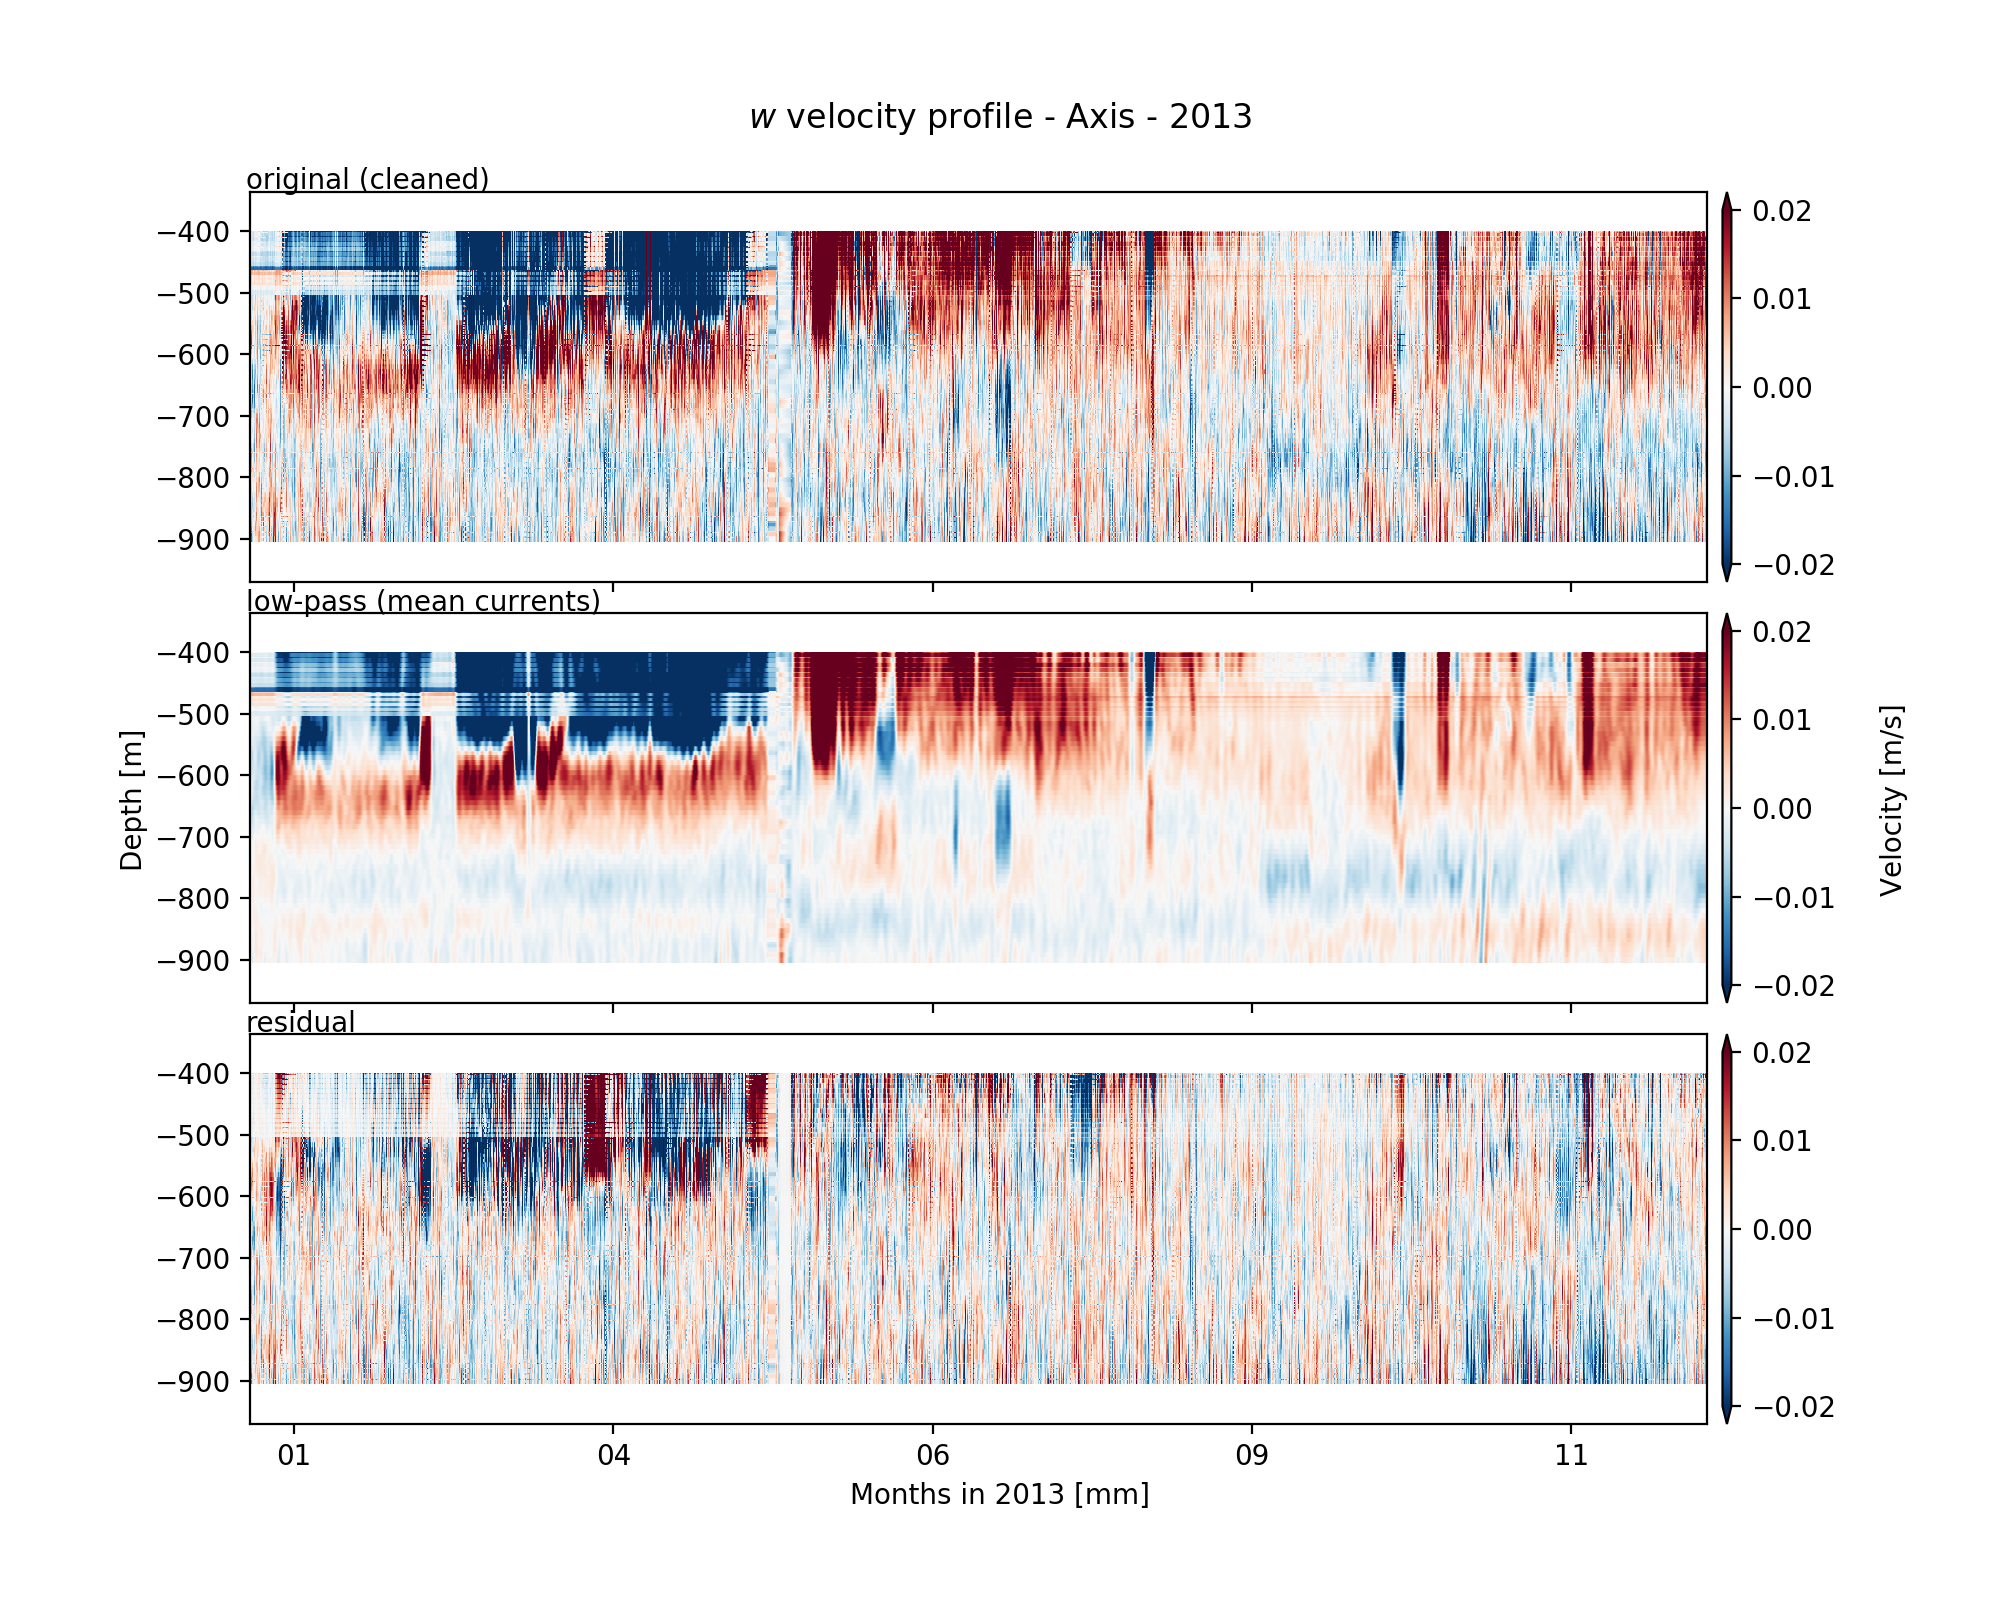

In [52]:
# plot w velocities
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace = 0.08,wspace = 0.05)
fig.text(0.5, 0.92, f'$w$ velocity profile - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (cleaned)', va='center')
fig.text(0.123, 0.623, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.360, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')

im1 = ax1.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
im2 = ax2.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

if adcp == 'Slope':
    ax1.set_ylim(-380,-13)
elif adcp == 'Axis':
    ax1.set_ylim(-970,-336)
elif adcp == 'Axis55':
    ax1.set_ylim(-970,-336)

date_form = pldates.DateFormatter("%m")
ax3.xaxis.set_major_formatter(date_form)
ax3.set_xlim(start_date,end_date)
#ax3.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
ax3.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

plt.savefig(fname='./plots/vel_plots/vel_w_'+adcp+'_'+t_stamp+'.pdf',format='pdf')